<a href="https://colab.research.google.com/github/SatioO/Kaggle/blob/master/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

In [0]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [3]:
train_idx = train["Id"]
test_idx = test["Id"]

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("The train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [4]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [5]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [0]:
corr_mat = train.corr()
corr_col = corr_mat.nlargest(10, 'SalePrice')['SalePrice'].index
corr_coef = np.corrcoef(train[corr_col].values.T)

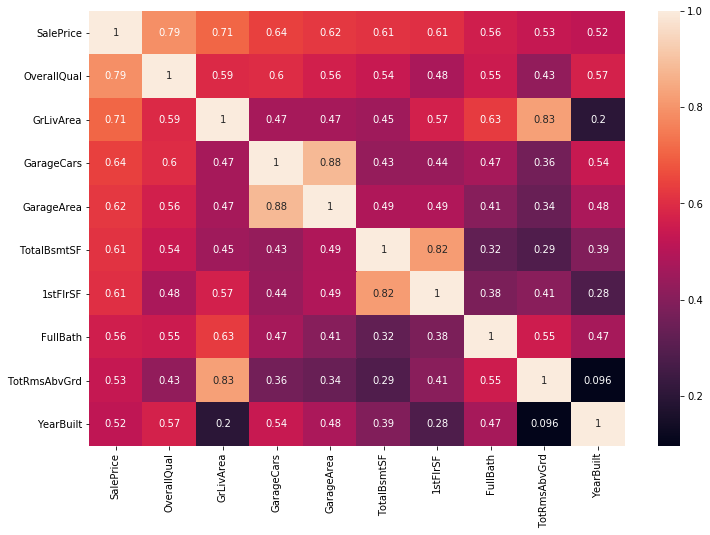

In [7]:
plt.subplots(1, figsize=(12, 8))
sns.heatmap(corr_coef, xticklabels=corr_col, yticklabels=corr_col, annot=True)

In [0]:
def get_missing(df):
  missing = df.isna().sum().sort_values(ascending=False)
  missing_df = pd.DataFrame(missing[missing > 0], columns=["Missing"])
  return missing_df

In [9]:
get_missing(all_data)

,Missing
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageCond,159
GarageQual,159
GarageYrBlt,159
GarageFinish,159


# Missing Values Imputation

In [0]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [0]:
all_data["PoolQC"].fillna("NA", inplace=True)
all_data["PoolArea"].fillna(0,  inplace=True)

all_data["Has_Pool"] = np.where(all_data["PoolArea"] > 0, 'Yes', 'No')
all_data.drop(["PoolArea", "PoolQC"], axis=1, inplace=True)

In [0]:
all_data.drop(["MiscFeature", "Fence"], axis=1, inplace=True)
all_data["Alley"].fillna("NA", inplace=True)

In [0]:
all_data["FireplaceQu"].fillna("NA", inplace=True)
all_data["Fireplaces"].fillna(0, inplace=True)

all_data["Has_Fireplaces"] = np.where(all_data["Fireplaces"] > 0, 'Yes', 'No')
all_data.drop(["FireplaceQu", "Fireplaces"], axis=1, inplace=True)

In [0]:
all_data["LotAreaCut"] = pd.qcut(all_data["LotArea"],10)
all_data["LotFrontage"] = all_data.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))
all_data["LotFrontage"] = all_data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x : x.fillna(x.median())) 

all_data.drop(["LotAreaCut"], inplace=True, axis=1)

In [0]:
all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace=True)

In [0]:
basement_variables = [
    'BsmtQual', # Basement quality
    'BsmtFullBath', # Basement full bathrooms
    'BsmtHalfBath', # Basement half bathrooms
    'BsmtExposure', # Walkout or garden level basement walls
    'BsmtFinType1', # Quality of basement finished area
    'BsmtFinType2', # Quality of second finished area (if present)
    'BsmtFinSF1', # Type 1 finished square feet
    'BsmtFinSF2', # Type 2 finished square feet
    'BsmtUnfSF', # Unfinished square feet of basement area
    'TotalBsmtSF', # Total square feet of basement area,
    'BsmtCond' # Basement condition
]

cat_basement_columns = all_data[basement_variables].select_dtypes(include="object").columns
num_basement_columns = all_data[basement_variables].select_dtypes(include=[np.number]).columns

all_data.loc[all_data["BsmtQual"].isna(), cat_basement_columns] = "None"
all_data.loc[all_data["BsmtQual"] == "None", num_basement_columns] = 0
all_data.loc[all_data["BsmtExposure"].isna(), "BsmtExposure"] = "No"

In [0]:
all_data.loc[all_data["BsmtFinType2"].isna(), "BsmtFinSF2"] = 0
all_data.loc[all_data["BsmtFinType2"].isna(), "BsmtFinType2"] = "Unf"
all_data.loc[all_data["BsmtCond"].isna(), "BsmtCond"] = "TA"
all_data.loc[all_data["BsmtFinType2"].isna(), "TotalBsmtSF"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"] + all_data["BsmtUnfSF"]

In [0]:
all_data["MasVnrArea"].fillna(0, inplace=True)
all_data["MasVnrType"].fillna("None", inplace=True)

In [0]:
all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace=True)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace=True)

In [0]:
all_data["Electrical"].fillna(all_data["Electrical"].mode()[0], inplace=True)

In [0]:
all_data.drop(['Utilities'], axis=1, inplace=True)
all_data["Functional"].fillna(all_data["Functional"].mode()[0], inplace=True)
all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0], inplace=True)
all_data["SaleType"].fillna(all_data["SaleType"].mode()[0], inplace=True)

# Feature Transformation

In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [0]:
numerical = all_data.select_dtypes(include=np.number).columns
categorical = all_data.select_dtypes(include="object").columns

all_data[numerical] = np.log1p(all_data[numerical])

In [0]:
y_train = np.log1p(y_train)

In [0]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoder = LabelEncoder()
scaler = MinMaxScaler()

all_data[numerical] = scaler.fit_transform(all_data[numerical])

for category in categorical:
  all_data[category] = encoder.fit_transform(all_data[category])

In [0]:
# print(f"Features before one hot encoding {all_data.shape}")
# all_data = pd.get_dummies(all_data)
# print(f"Features after one hot encoding {all_data.shape}")

In [27]:
all_train = all_data[:ntrain]
all_train["SalePrice"] = y_train

all_test = all_data[ntrain:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Outliers Detection Process

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


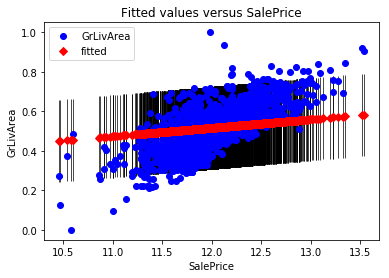

In [28]:
import statsmodels.api as smapi
import statsmodels.graphics as smgraphics

model = smapi.OLS(all_train["GrLivArea"], all_train["SalePrice"]).fit()
figure = smgraphics.regressionplots.plot_fit(model, 0)
test = model.outlier_test()
outliers = ((all_train["GrLivArea"][i], all_train["SalePrice"][i]) for i,t in enumerate(test.values) if t[2] < 0.2)
for i in outliers:
  all_train.drop(all_train[all_train["GrLivArea"] == i[0]].index, axis=0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


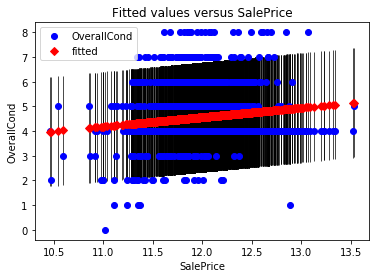

In [29]:
model = smapi.OLS(all_train["OverallCond"], all_train["SalePrice"]).fit()
figure = smgraphics.regressionplots.plot_fit(model, 0)
test = model.outlier_test()
outliers = ((all_train["OverallCond"][i], all_train["SalePrice"][i]) for i,t in enumerate(test.values) if t[2] < 0.5)

for i in outliers:
  all_train.drop(all_train[all_train["OverallQual"] == i[0]].index, axis=0, inplace=True)

In [0]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(all_train.loc[:, all_train.columns != 'SalePrice'], all_train["SalePrice"], test_size=0.25)

# Modelling Process

In [0]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb


kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train_x.values)

# Model Comparisions

#### Lasso: 0.1223
#### Ridge: 0.1225
#### XGB: 0.1184
#### GBoost: 0.1196
#### LightGBM: 0.1202



In [0]:
def rmsle_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_x.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [33]:
lasso_params = {'alpha':[0.001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]}
# lasso = GridSearchCV(Lasso(), param_grid=lasso_params, cv=kf).fit(train_x, train_y).best_estimator_
# print(lasso)

lasso = Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Lasso score: 0.1223 (0.0066)



In [34]:
kernal_ridge_params = {
    'alpha':[0.001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05],
    'kernel': ['linear', 'polynomial'],
    'degree': [1,2,3,4],
    'coef0': [1, 1.5, 2, 2.5, 3]
}

# KRR = GridSearchCV(KernelRidge(), param_grid=kernal_ridge_params, cv=kf).fit(train_x, train_y).best_estimator_
# print(KRR)

KRR = KernelRidge(alpha=0.003, coef0=3, degree=1, gamma=None, kernel='polynomial',
            kernel_params=None)

score = rmsle_cv(KRR)
print("\nKernal Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KernelRidge(alpha=0.003, coef0=3, degree=1, gamma=None, kernel='polynomial',
            kernel_params=None)

Kernal Ridge score: 0.1225 (0.0059)



In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("\nXGB score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/x

In [0]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))